# Case Study 5 - Produce farm zone map
## Description 
As a grower, I want to analyse my yield maps and farm data, so I can zone up my farm based on site variability. 
## Case Breakdown 
- **Actors:** Grower
- **Goals:** Customized needs for Grower
- **Scope** Local,Paddock-Scale
## Generalised case
I want to analyse a suite of spatial variables across a site so I can derive a classification of areas by similarity.
## Comparable cases
- I want to combine a suite of environmental variables, including weather (temperature, rainfall, humidity - all xyt), lunar phase (t) and greenness (xyt - see https://portal.tern.org.au/metadata/TERN/8542d90e-6e20-4ad8-b30d-0a171b61d3f5) and soils (pH, N, K, structure) for N (e.g. 50) candidate sites and then select derive a classification for each subunit based on a clustering algorithm.


## Data Sources
Use Llara-Campey data including yield values and soil maps to develop classification of farm area into contiguous zones of relatively self-similar productivity. Variables should include the minimum zone area and the maximum number of zone classes to return.

This notebook can be delivered as a tool into which the user can load their own data in the form of spreadsheets containing points and associated values for the variables to take into account in the analysis. The requirement is either for comprehensive (raster) coverage for the area or of a set of point-based measurements for each variable (in which case a simple kriging or mesh interpolation will be applied).

### Generating STAC records from config files

In [1]:
from concurrent.futures import ProcessPoolExecutor
from stac_generator.factory import StacGeneratorFactory
from stac_generator.core import StacCollectionConfig, StacSerialiser
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

parent_path = Path().cwd()
# Scenario 1
configs = [
    parent_path / "llara_point_config.json",
    parent_path / "llara_shape_config.json",
    parent_path / "scenario_1_config.json",
]
stac_path = parent_path / "scenario_1"
collection_config = StacCollectionConfig(id="Collection")

# Serialising STAC records
with ProcessPoolExecutor(max_workers=8) as pool:
    generator = StacGeneratorFactory.get_collection_generator(
        source_configs=configs, collection_config=collection_config, pool=pool
    )
    serialiser = StacSerialiser(generator, stac_path.as_posix())
    serialiser()

2025-05-26T15:12:23-stac_generator.core.point.generator - INFO - Reading point asset: soil_measurement
2025-05-26T15:12:23-stac_generator.core.vector.generator - INFO - Reading vector asset: L1Boundary
2025-05-26T15:12:23-stac_generator.core.vector.generator - INFO - Reading vector asset: L3Boundary
2025-05-26T15:12:23-stac_generator.core.point.generator - INFO - Reading point asset: L1_2017_wheat
2025-05-26T15:12:23-stac_generator.core.point.generator - INFO - Reading point asset: L4_2017_wheat
2025-05-26T15:12:23-stac_generator.core.point.generator - INFO - Reading point asset: L3_2017_wheat
2025-05-26T15:12:23-stac_generator.core.vector.generator - INFO - Reading vector asset: L4Boundary
2025-05-26T15:12:24-stac_generator.core.base.generator - INFO - successfully save collection Collection to /home/harry/CodingProject/mccn-case-studies/Case 5/scenario_1


### Loading raw data using the MCCN Engine

In [2]:
# Loading in data cube
from mccn.client import MCCN

client = MCCN(endpoint=stac_path / "collection.json", shape=(100, 100))
raw_ds = client.load()

In [3]:
raw_ds

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 2, y: 100, x: 100)
Coordinates:
  * y            (y) float64 800B -30.26 -30.26 -30.26 ... -30.29 -30.29 -30.29
  * x            (x) float64 800B 149.8 149.8 149.8 149.8 ... 149.9 149.9 149.9
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 16B 2016-01-01 2017-01-01
Data variables:
    L1Boundary   (time, y, x) int8 20kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    L3Boundary   (time, y, x) int8 20kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    L4Boundary   (time, y, x) int8 20kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    Silt         (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Clay         (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    GammaK       (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ECa          (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Sand         (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    EC           (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pH           (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    yield_t_ha   (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    moisture     (time, y, x) float64 160kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    L1Boundary:  {0: 'nodata', 1: 'L1Boundary'}
    L3Boundary:  {0: 'nodata', 1: 'L3Boundary'}
    L4Boundary:  {0: 'nodata', 1: 'L4Boundary'}

### Preprocessing - Combining dates 

Our dataset has two time periods - 2016, 2017. The soil variables were collected in 2016 and the yield data collected in 2017. For convenience, we will assume that the soil measurements in 2016 are still valid in 2017 and remove the time dimension of the cube.

In [4]:
axis = {1: ["yield_t_ha"]}
# Repeat and extract to 2016 for convenience
proc_ds = raw_ds.copy()
for idx, vars in axis.items():
    for var in vars:
        proc_ds[var].values = np.repeat(
            np.expand_dims(proc_ds[var].values[idx, :, :], 0), 2, axis=0
        )

# Slice 2016, selecting only relevant variables and removing time dimension
proc_ds = proc_ds[
    [
        # Boundary values
        "L1Boundary",
        "L3Boundary",
        "L4Boundary",
        # Predictors
        "pH",
        "EC",
        "Sand",
        "Silt",
        "Clay",
        "ECa",
        "GammaK",
        # Response
        "yield_t_ha",
    ]
].isel(time=0)

# Make a mask layer based on the values of L1, L3, L4 boundaries
# Note we also mask based on yield values
mask = proc_ds["yield_t_ha"]

In [5]:
proc_ds

<xarray.Dataset> Size: 672kB
Dimensions:      (y: 100, x: 100)
Coordinates:
  * y            (y) float64 800B -30.26 -30.26 -30.26 ... -30.29 -30.29 -30.29
  * x            (x) float64 800B 149.8 149.8 149.8 149.8 ... 149.9 149.9 149.9
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2016-01-01
Data variables:
    L1Boundary   (y, x) int8 10kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    L3Boundary   (y, x) int8 10kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    L4Boundary   (y, x) int8 10kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    pH           (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    EC           (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Sand         (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Silt         (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Clay         (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ECa          (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GammaK       (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    yield_t_ha   (y, x) float64 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    L1Boundary:  {0: 'nodata', 1: 'L1Boundary'}
    L3Boundary:  {0: 'nodata', 1: 'L3Boundary'}
    L4Boundary:  {0: 'nodata', 1: 'L4Boundary'}

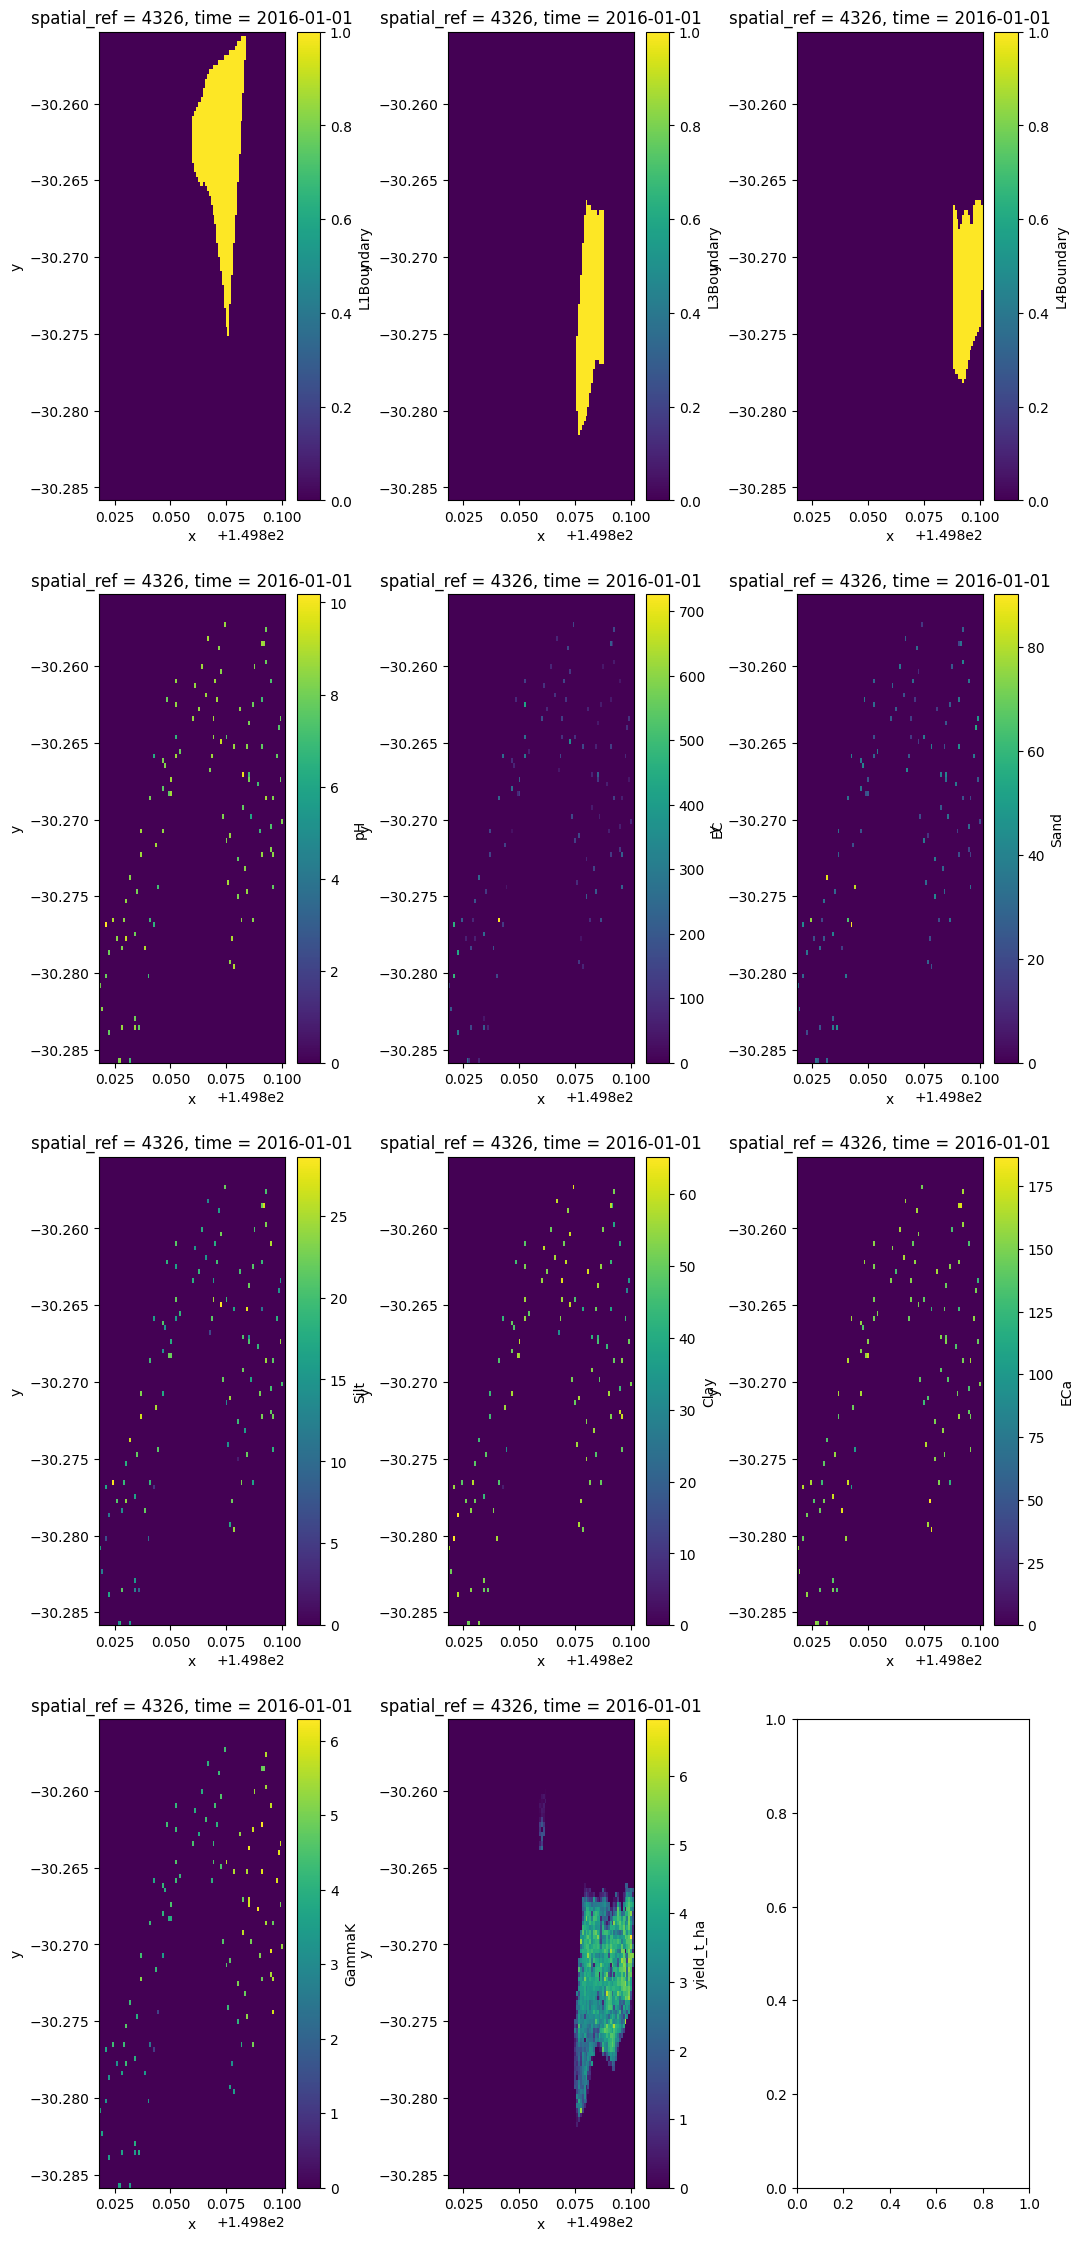

In [6]:
# Visualising variables
f, subplots = plt.subplots(4, 3, figsize=(12, 28), squeeze=True)
plt.subplots_adjust(wspace=0.5, hspace=0.2)  # Adjust the spacing
i, j = 0, 0
for var in proc_ds.data_vars.keys():
    proc_ds[var].plot(ax=subplots[j, i], x="x", y="y")
    i, j = (0, j + 1) if i == 2 else (i + 1, j)

### Processing - Applying Ordinary Krigging

In [7]:
import pykrige
import xarray as xr

# Krig all relevant predictor variables
krig_var = ["pH", "EC", "Sand", "Silt", "Clay", "ECa", "GammaK"]
for var in krig_var:
    grid = np.array(
        [
            (proc_ds["x"].values[i], proc_ds["y"].values[j], proc_ds[var].values[i, j])
            for i in range(len(proc_ds["x"]))
            for j in range(len(proc_ds["y"]))
            if proc_ds[var].values[i, j] > 0
        ]
    )
    if len(grid) != 0:
        model = pykrige.ok.OrdinaryKriging(
            grid[:, 0], grid[:, 1], grid[:, 2], variogram_function="linear", exact_values=False,
        )
        krigged_var, _ = model.execute("grid", proc_ds["x"].values, proc_ds["y"].values)
        proc_ds["Krigged_" + var] = xr.DataArray(
            krigged_var.data, coords={"y": proc_ds["y"], "x": proc_ds["x"]}
        )
        proc_ds["Krigged_" + var] = proc_ds["Krigged_" + var].where(mask.squeeze(), 0)


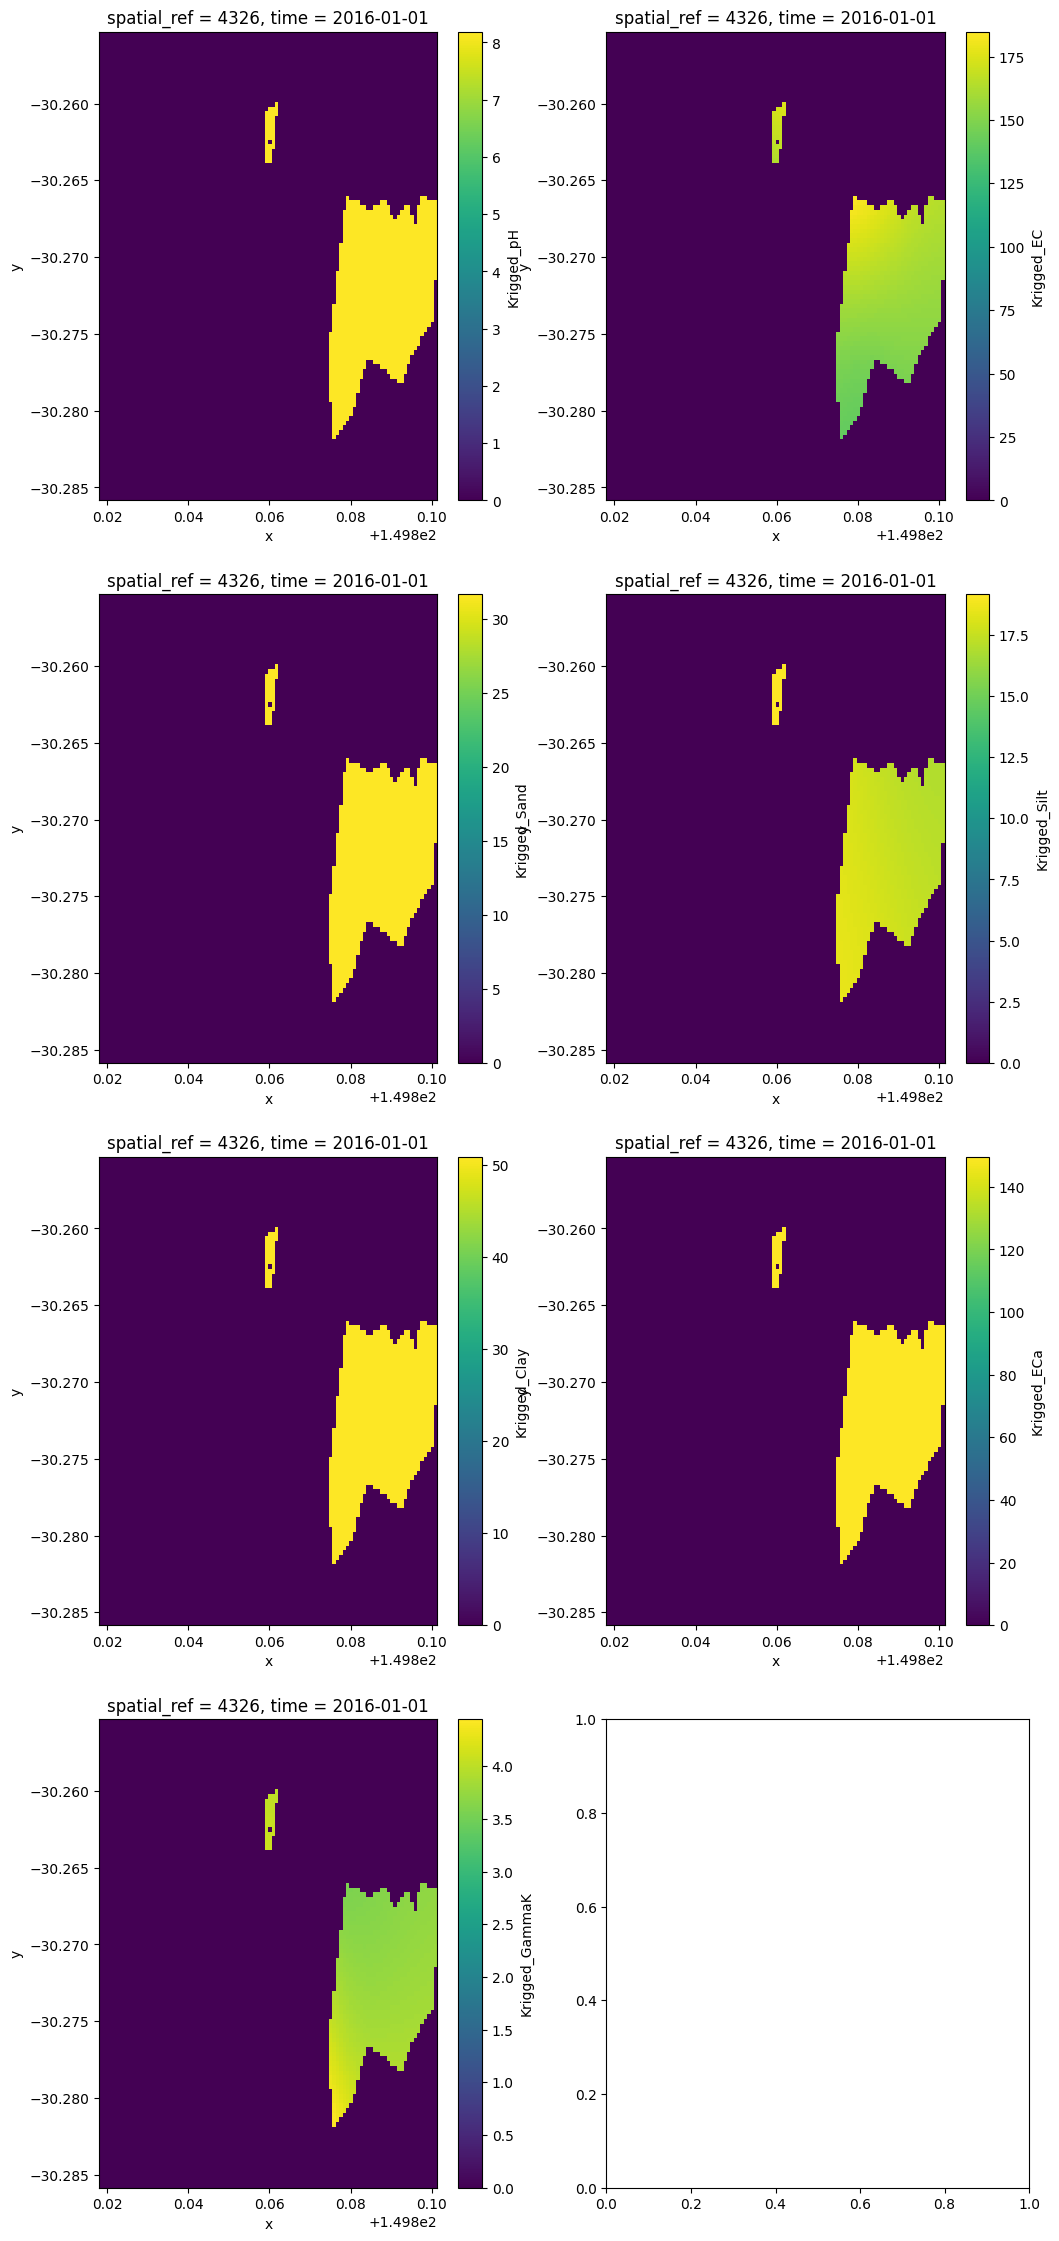

In [8]:
plot_vars = ["Krigged_" + var for var in krig_var]

# Visualising variables
f, subplots = plt.subplots(4, 2, figsize=(12, 28), squeeze=True)
i, j = 0, 0
for var in plot_vars:
    proc_ds[var].plot(ax=subplots[j, i], x="x", y="y")
    i, j = (0, j + 1) if i == 1 else (i + 1, j)

### Perform field zoning based on yield data

We will be using the [KMeans](https://en.wikipedia.org/wiki/K-means_clustering) algorithm for clustering Llara into different management zones. We visualise the yield data by itself.

In [9]:
from sklearn.cluster import KMeans

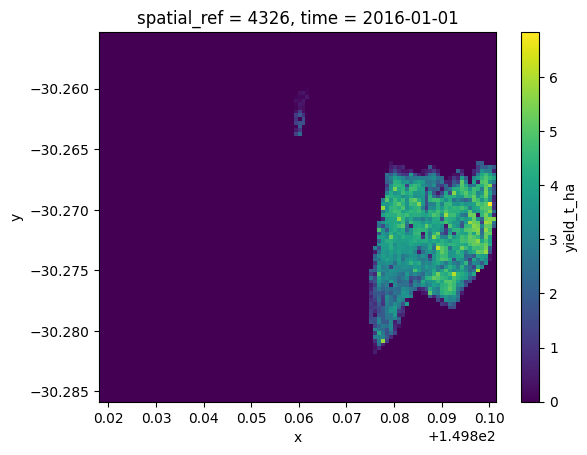

In [10]:
# Plotting Yield layer data
proc_ds["yield_t_ha"].plot(x="x", y="y")

We use the yield data together with a combination of Krigged predictors - EC, ECa, GammaK, Sand, Silt, Clay and location data (X, Y) for clutering.
The clutering algorithm used is [KMeans](https://en.wikipedia.org/wiki/K-means_clustering), which groups each point by Euclidean distance across the clustering variables.

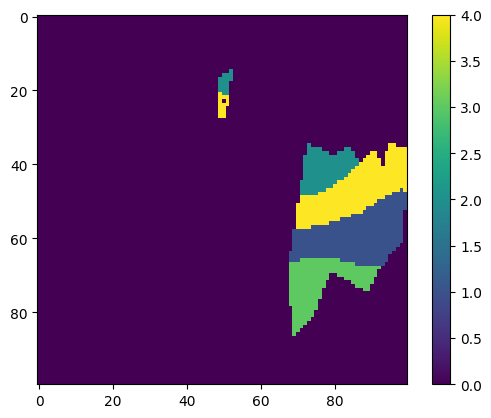

In [11]:
variables = proc_ds[
    [
        "Krigged_EC",
        "Krigged_ECa",
        "Krigged_GammaK",
        "Krigged_Sand",
        "Krigged_Silt",
        "Krigged_Clay",
        "yield_t_ha",
    ]
]
x_grid, y_grid = np.meshgrid(proc_ds["x"].values, proc_ds["y"].values, indexing="ij")
x_val = x_grid.reshape(-1, 1) 
y_val = y_grid.reshape(-1, 1) 
X = [x_val, y_val]

# Preprocess variables
for var in variables:
    values = variables[var].values[:, :].reshape(-1, 1)
    X.append(values)
X = np.concat(X, axis=-1)

# Cluster
clusterer = KMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(X)
proc_ds["cluster_label"] = xr.DataArray(
            cluster_labels.reshape(100,100), coords={"y": proc_ds["y"], "x": proc_ds["x"]}
)
plt.imshow(cluster_labels.reshape(100, 100))
plt.colorbar()
plt.show()

### Clean up 

Provide an RO Crate file that describes the project.

In [21]:
from rocrate.rocrate import ROCrate
from rocrate.model import ComputationalWorkflow, File, ContextEntity, Person

# Save output datasets
notebook = "MCCN-CASE 5.ipynb"
ro_crate = "MCCN-CASE 5.RO-Crate.zip"
result_path = Path("result")
result_path.mkdir(exist_ok=True)
datacube_final_path = (result_path / "datacube_final.cd").as_posix()
datacube_initial_path = (result_path / "datacube_initial.cd").as_posix()
MCCN.to_netcdf(raw_ds, datacube_initial_path) 
MCCN.to_netcdf(proc_ds, datacube_final_path)

# Package notebook, source data and outputs as an RO-Crate
source_path = Path("data")
boundary_source = (source_path / "boundary_wgs84.zip").as_posix()
soil_source = (source_path / "soil_data.csv").as_posix()
L1_2017_wheat_source = (source_path / "L1_2017_wheat.txt").as_posix()
L3_2017_wheat_source = (source_path / "L3_2017_wheat.txt").as_posix()
L4_2017_wheat_source = (source_path / "L4_2017_wheat.txt").as_posix()

crate = ROCrate()
ardc = crate.add(ContextEntity(crate, "https://ror.org/038sjwq14", properties={
    "@type": "Organisation",
    "name": "Australian Research Data Commons"
}))
appn = crate.add(ContextEntity(crate, "https://ror.org/02zj7b759", properties={
    "@type": "Organisation",
    "name": "Australian Plant Phenomics Network"
}))
dgh = crate.add(Person(crate, "https://orcid.org/0000-0001-6492-4016", properties={
    "name": "Donald Hobern",
    "email": "donald.hobern@adelaide.edu.au",
    "affiliation": {"@id": appn.id},
    "jobTitle": "APPN Data Management Director",
}))
food_security = crate.add(ContextEntity(crate, "https://doi.org/10.47486/DC105", properties={
    "@type": "Grant",
    "name": "ARDC Project Code DC105: Multi-Scalar Crop Characterisation Network (MCCN)",
    "funder": {"@id": ardc.id}
}))
mccn = crate.add(ContextEntity(crate, "https://doi.org/10.26292/8679d473", properties={
    "@type": "ResearchActivity",
    "name": "Multi-Scalar Crop Characterisation Network (MCCN)",
    "funding": {"@id": food_security.id},
    "contactPoint": {"@id": dgh.id},
}))
cc_by = crate.add(ContextEntity(crate, "https://creativecommons.org/licenses/by/4.0/", properties={
    "@type": "License",
    "name": "Creative Commons Attribution 4.0 International (CC BY 4.0)",
}))
crate_properties = crate.default_entities[0].properties()
crate_properties |= {
    "name": "MCCN Case Study 5 - source data, notebook and results",
    "description": "This RO-Crate is a packaged version of the Jupyter notebook for Case Study 5 of the Multiscalar Crop Characterisation Network (MCCN) project. It demonstrates the functionality of the Python packages pystac-generator and mccn-engine developed as part of this project.",
    "license": {"@id": cc_by.id},
    "isBasedOn": {"@id": mccn.id},
}
crate.add(File(crate, source=L1_2017_wheat_source, dest_path=L1_2017_wheat_source, properties={
    "name": "Yield and moisture data collected for L1 site in 2017",
    "encodingFormat": "text/csv",
    "producer": "usyd.edu.au",
    "citation": "University of Sydney",
    "license": {"@id": cc_by.id},
    "url": {"@id": "https://object-store.rc.nectar.org.au/v1/AUTH_2b454f47f2654ab58698afd4b4d5eba7/mccn-test-data/LlaraCampey/L1_2017_wheat.txt"}
}))
crate.add(File(crate, source=L3_2017_wheat_source, dest_path=L3_2017_wheat_source, properties={
    "name": "Yield and moisture data collected for L3 site in 2017",
    "encodingFormat": "text/csv",
    "producer": "usyd.edu.au",
    "citation": "University of Sydney",
    "license": {"@id": cc_by.id},
    "url": {"@id": "https://object-store.rc.nectar.org.au/v1/AUTH_2b454f47f2654ab58698afd4b4d5eba7/mccn-test-data/LlaraCampey/L3_2017_wheat.txt"}
}))
crate.add(File(crate, source=L4_2017_wheat_source, dest_path=L4_2017_wheat_source, properties={
    "name": "Yield and moisture data collected for L4 site in 2017",
    "encodingFormat": "text/csv",
    "producer": "usyd.edu.au",
    "citation": "University of Sydney",
    "license": {"@id": cc_by.id},
    "url": {"@id": "https://object-store.rc.nectar.org.au/v1/AUTH_2b454f47f2654ab58698afd4b4d5eba7/mccn-test-data/LlaraCampey/L4_2017_wheat.txt"}
}))
crate.add(File(crate, source=soil_source, dest_path=soil_source, properties={
    "name": "Soil measurements from 2004, corresponding to sites L1, L3 and L4 describing mid-depth, soil apparent electrical conductivity (ECa), GammaK, Clay, Silt, Sand, pH and soil electrical conductivity (EC)",
    "encodingFormat": "text/csv",
    "producer": "usyd.edu.au",
    "citation": "University of Sydney",
    "license": {"@id": cc_by.id},
    "url": {"@id": "https://object-store.rc.nectar.org.au/v1/AUTH_2b454f47f2654ab58698afd4b4d5eba7/mccn-test-data/LlaraCampey/soil_data.csv"}
}))
crate.add(File(crate, source=boundary_source, dest_path=boundary_source, properties={
    "name": "Shape file of outer boundary for wheat experiments conducted at Llara farm site L1, L3, L4 in 2017, 2019 and 2021 measuring yield, elevation and moisture",
    "encodingFormat": "application/octet-stream",
    "producer": "usyd.edu.au",
    "citation": "University of Sydney",
    "license": {"@id": cc_by.id},
    "url": {"@id": "https://object-store.rc.nectar.org.au/v1/AUTH_2b454f47f2654ab58698afd4b4d5eba7/mccn-test-data/LlaraCampey/boundary_wgs84.zip"}
}))
crate.add(File(crate, source=datacube_initial_path, dest_path=datacube_initial_path, properties={
    "name": "Xarray datacube as loaded from source data files by MCCN Case Study 5",
    "license": {"@id": cc_by.id},
    "encodingFormat": "application/x-netcdf",
    "producer": {"@id": appn.id},
}))
crate.add(File(crate, source=datacube_final_path, dest_path=datacube_final_path, properties={
    "name": "Xarray datacube following processing by MCCN Case Study 5",
    "license": {"@id": cc_by.id},
    "encodingFormat": "application/x-netcdf",
    "producer": {"@id": appn.id},
}))
crate.add(ComputationalWorkflow(crate, source=notebook, dest_path=notebook, properties={
    "name": "MCCN Case Study 5 Notebook: Produce Farm Zone Map",
    "encodingFormat": "application/x-ipynb+json",
    "creator": {"@id": dgh.id},
    "license": {"@id": cc_by.id},
    "isBasedOn": {"@id": mccn.id},
    "input": [
        { "@id": boundary_source},
        { "@id": soil_source},
        { "@id": L1_2017_wheat_source},
        { "@id": L3_2017_wheat_source},
        { "@id": L4_2017_wheat_source},
    ],
    "output": [
        { "@id": datacube_initial_path},
        { "@id": datacube_final_path},
    ],
}))
crate.write_zip(ro_crate)

'/home/harry/CodingProject/mccn-case-studies/Case 5/MCCN-CASE 5.RO-Crate.zip'